# Wildlife Species Detection from Drone Imagery
## Data Exploration – WAID Dataset

**Project Objective:**  
This notebook explores the Wildlife Aerial Images from Drone (WAID) dataset.  
We analyze class distribution, image characteristics, and annotation quality to
ensure suitability for training deep learning–based object detection models.

**Dataset:** Wildlife Aerial Images from Drone (WAID)  
**Species:** Sheep, Cattle, Seal, Camelus, Kiang, Zebra


In [14]:
# Core libraries
import os
import json
import numpy as np
import pandas as pd

# Computer vision
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from collections import Counter
from tqdm import tqdm
from collections import defaultdict

# Plot settings
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)


In [15]:
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Project paths
PROJECT_ROOT = os.path.abspath("..")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")

IMAGE_DIR = os.path.join(RAW_DATA_DIR, "images")
ANNOTATION_DIR = os.path.join(RAW_DATA_DIR, "annotations")
SPLITS = ["train", "valid", "test"]

print("Image directory:", IMAGE_DIR)
print("Annotation directory:", ANNOTATION_DIR)

Image directory: c:\Users\lena\OneDrive - De Vinci\RECOVER\S9\Computer Vision\detection-and-identification-of-wildlife-populations-from-drone-images\data\raw\images
Annotation directory: c:\Users\lena\OneDrive - De Vinci\RECOVER\S9\Computer Vision\detection-and-identification-of-wildlife-populations-from-drone-images\data\raw\annotations


## Dataset Overview

In this section, we:
- Inspect the number of images and annotations
- Examine image resolution and formats
- Analyze the distribution of wildlife species


In [16]:

image_files = defaultdict(list)
annotation_files = defaultdict(list)

for split in SPLITS:
    image_split_dir = os.path.join(IMAGE_DIR, split)
    ann_split_dir = os.path.join(ANNOTATION_DIR, split)

    image_files[split] = sorted([
        f for f in os.listdir(image_split_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

    annotation_files[split] = sorted([
        f for f in os.listdir(ann_split_dir)
        if f.lower().endswith(".txt")
    ])

    print(f"{split.upper()} → images: {len(image_files[split])}, "
          f"annotations: {len(annotation_files[split])}")


TRAIN → images: 10056, annotations: 10056
VALID → images: 2873, annotations: 2873
TEST → images: 1437, annotations: 1437


In [17]:
sample_img = cv2.imread(os.path.join(IMAGE_DIR, "train", image_files["train"][0]))
h, w, c = sample_img.shape

print(f"Image resolution: {w} x {h}")
print(f"Channels: {c}")

Image resolution: 640 x 640
Channels: 3


In [23]:
# Load class names
CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")

with open(CLASSES_PATH, "r") as f:
    CLASS_NAMES = [line.strip() for line in f if line.strip()]

NUM_CLASSES = len(CLASS_NAMES)

print("Loaded classes:")
for i, name in enumerate(CLASS_NAMES):
    print(f"{i}: {name}")

Loaded classes:
0: sheep
1: cattle
2: seal
3: kiang
4: camelus
5: zebra


In [24]:
def load_yolo_annotations(file_path, num_classes):
    """
    Load YOLO annotations from a single file.

    Returns:
        List of class IDs (int)
    """
    class_ids = []

    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines

            class_id = int(parts[0])

            # Safety check
            if class_id < 0 or class_id >= num_classes:
                raise ValueError(
                    f"Invalid class ID {class_id} in {file_path}"
                )

            class_ids.append(class_id)

    return class_ids

In [25]:
def get_image_labels(image_name, split, class_names):
    """
    Return a sorted list of unique class names present in an image.
    """
    ann_name = os.path.splitext(image_name)[0] + ".txt"
    ann_path = os.path.join(ANNOTATION_DIR, split, ann_name)

    if not os.path.exists(ann_path):
        return []

    class_ids = load_yolo_annotations(ann_path, len(class_names))
    labels = sorted({class_names[cid] for cid in class_ids})

    return labels

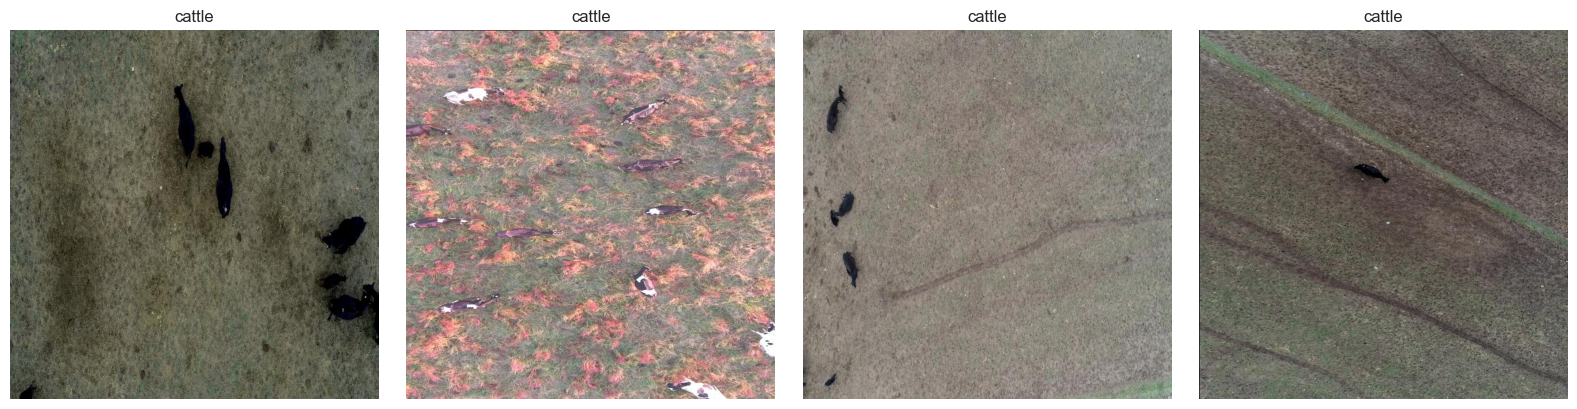

In [26]:
def show_images(image_files, split="train", n=4):
    """
    Display n sample images with species labels as titles.
    """
    images = image_files[split][:n]

    plt.figure(figsize=(4 * n, 4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(IMAGE_DIR, split, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        labels = get_image_labels(img_name, split, CLASS_NAMES)
        title = ", ".join(labels) if labels else "No labels"

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(image_files, split="train", n=4)

In [27]:
all_class_ids = []

for split in SPLITS:
    for ann_file in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann_file)
        class_ids = load_yolo_annotations(ann_path, NUM_CLASSES)
        all_class_ids.extend(class_ids)

print(f"Total labeled objects across all splits: {len(all_class_ids)}")

Total labeled objects across all splits: 233806


In [28]:
all_class_names = [CLASS_NAMES[cid] for cid in all_class_ids]

class_counts = Counter(all_class_names)

class_counts

Counter({'sheep': 130882,
         'cattle': 63090,
         'seal': 23377,
         'kiang': 6623,
         'zebra': 5225,
         'camelus': 4609})

In [29]:
df_classes = (
    pd.DataFrame(class_counts.items(), columns=["Species", "Count"])
      .sort_values("Count", ascending=False)
      .reset_index(drop=True)
)

df_classes

,Species,Count
0,sheep,130882
1,cattle,63090
2,seal,23377
3,kiang,6623
4,zebra,5225
5,camelus,4609


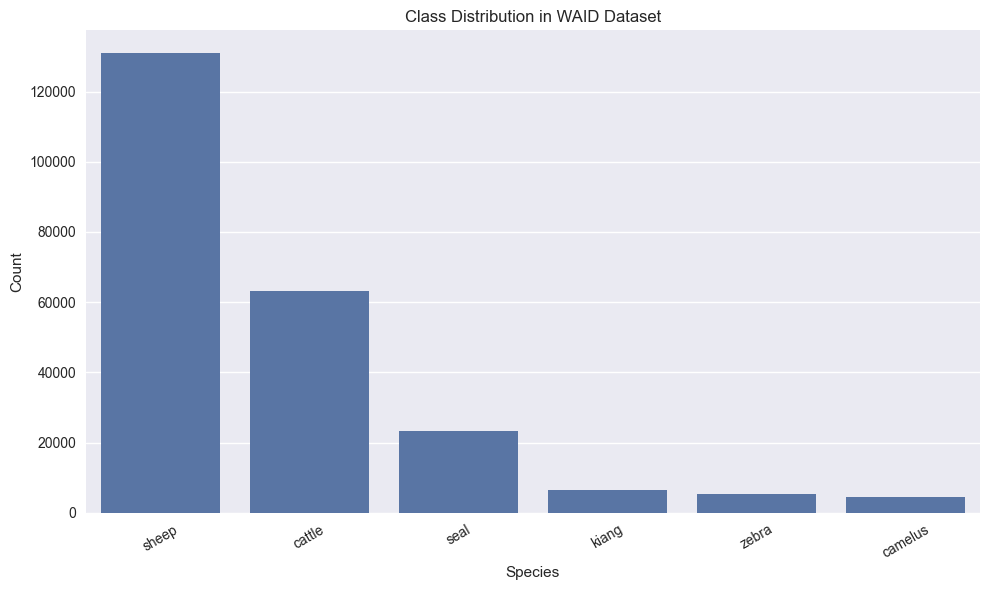

In [30]:
sns.barplot(data=df_classes, x="Species", y="Count")
plt.title("Class Distribution in WAID Dataset")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [31]:
def get_bbox_sizes(annotation_path):
    """
    Returns list of bounding box areas (normalized) from a YOLO annotation file.
    """
    sizes = []

    with open(annotation_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            _, _, _, w, h = map(float, parts)
            sizes.append(w * h)

    return sizes

In [32]:
all_bbox_areas = []

for split in SPLITS:
    for ann in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann)
        all_bbox_areas.extend(get_bbox_sizes(ann_path))

print(f"Total bounding boxes: {len(all_bbox_areas)}")

Total bounding boxes: 233806


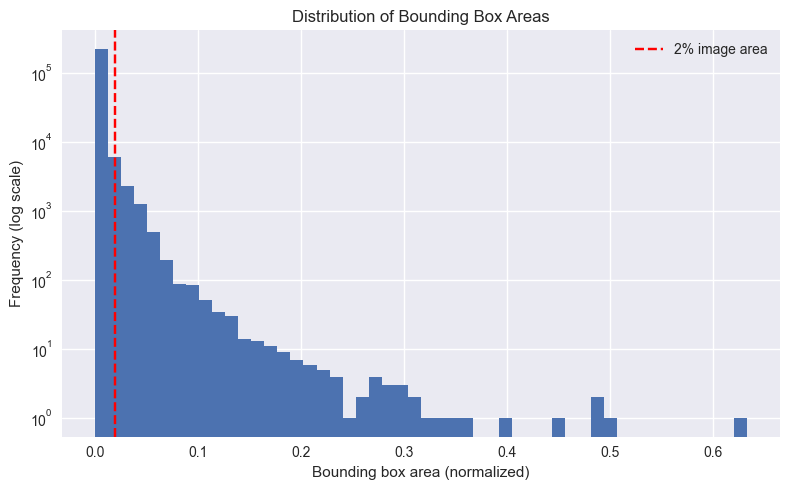

In [33]:
plt.figure(figsize=(8, 5))
plt.hist(all_bbox_areas, bins=50, log=True)
plt.axvline(0.02, color="red", linestyle="--", label="2% image area")
plt.xlabel("Bounding box area (normalized)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Bounding Box Areas")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
small_objects_ratio = sum(a < 0.02 for a in all_bbox_areas) / len(all_bbox_areas)

print(f"{small_objects_ratio:.2%} of objects occupy less than 2% of the image area")

97.15% of objects occupy less than 2% of the image area


In [35]:
bbox_areas_per_class = {name: [] for name in CLASS_NAMES}

for split in SPLITS:
    for ann in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann)
        with open(ann_path, "r") as f:
            for line in f:
                cid, _, _, w, h = map(float, line.split())
                bbox_areas_per_class[CLASS_NAMES[int(cid)]].append(w * h)

C:\Users\lena\AppData\Local\Temp\ipykernel_30044\1734880440.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


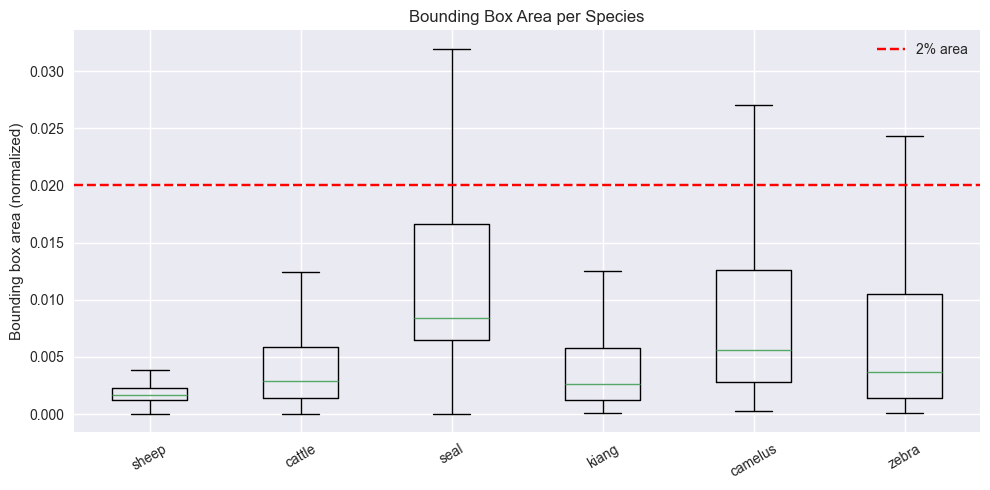

In [36]:
plt.figure(figsize=(10, 5))
plt.boxplot(
    bbox_areas_per_class.values(),
    labels=bbox_areas_per_class.keys(),
    showfliers=False
)
plt.axhline(0.02, color="red", linestyle="--", label="2% area")
plt.ylabel("Bounding box area (normalized)")
plt.title("Bounding Box Area per Species")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
objects_per_image = []

for split in SPLITS:
    for ann in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann)
        with open(ann_path) as f:
            objects_per_image.append(len(f.readlines()))

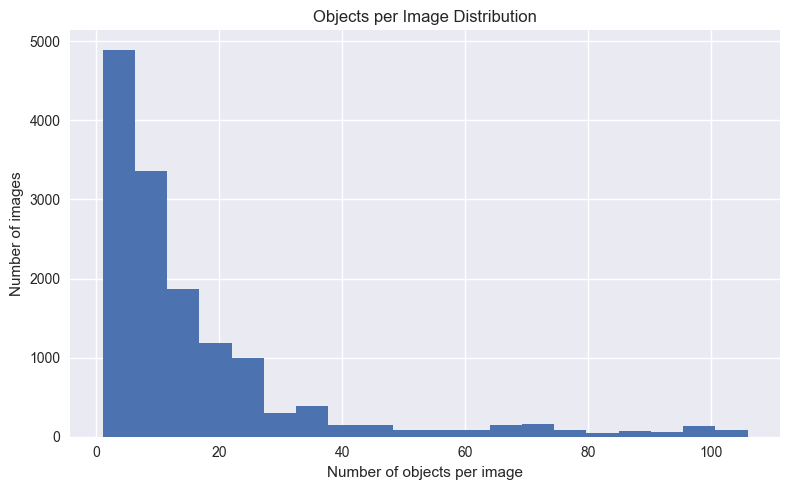

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(objects_per_image, bins=20)
plt.xlabel("Number of objects per image")
plt.ylabel("Number of images")
plt.title("Objects per Image Distribution")
plt.tight_layout()
plt.show()

In [39]:
print(f"Mean objects per image: {np.mean(objects_per_image):.2f}")
print(f"Max objects in an image: {np.max(objects_per_image)}")

Mean objects per image: 16.27
Max objects in an image: 106


In [40]:
from itertools import combinations
from collections import Counter

co_occurrence = Counter()

for split in SPLITS:
    for ann in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann)
        class_ids = load_yolo_annotations(ann_path, NUM_CLASSES)

        unique_ids = set(class_ids)
        for pair in combinations(sorted(unique_ids), 2):
            co_occurrence[pair] += 1

In [42]:
co_occurrence_named = {
    (CLASS_NAMES[a], CLASS_NAMES[b]): count
    for (a, b), count in co_occurrence.items()
}

pd.DataFrame(
    co_occurrence_named.items(),
    columns=["Species Pair", "Count"]
).sort_values("Count", ascending=False).head(10)

,Species Pair,Count


In [43]:
empty_files = []

for split in SPLITS:
    for ann in annotation_files[split]:
        ann_path = os.path.join(ANNOTATION_DIR, split, ann)
        if os.path.getsize(ann_path) == 0:
            empty_files.append((split, ann))

In [44]:
if empty_files:
    print(f"Found {len(empty_files)} empty annotation files:")
    empty_files[:5]
else:
    print("No empty annotation files found ✅")

No empty annotation files found ✅


In [47]:
import math

def show_one_image_per_class(
    image_files,
    split="train",
    class_names=None,
    n_cols=3
):
    """
    Display one image per class arranged in a grid layout.
    """
    assert class_names is not None, "class_names must be provided"

    # Map: class_name -> image_name
    class_to_image = {}

    for img_name in image_files[split]:
        labels = get_image_labels(img_name, split, class_names)

        for label in labels:
            if label not in class_to_image:
                class_to_image[label] = img_name

        if len(class_to_image) == len(class_names):
            break

    n_classes = len(class_to_image)
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )

    axes = axes.flatten()

    for ax, (label, img_name) in zip(axes, class_to_image.items()):
        img_path = os.path.join(IMAGE_DIR, split, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")

    # Turn off unused axes
    for ax in axes[len(class_to_image):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

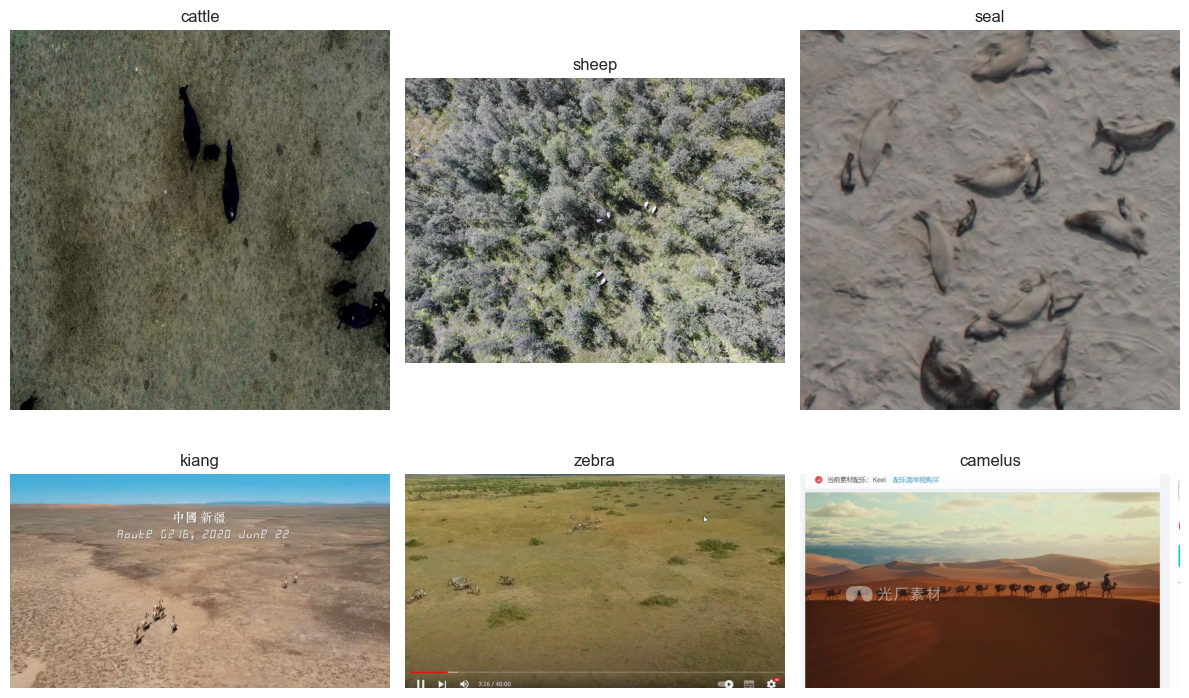

In [48]:
show_one_image_per_class(
    image_files,
    split="train",
    class_names=CLASS_NAMES,
    n_cols=3
)